In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

df=pd.read_csv('covid_pa_confirmed_data_7d.csv',parse_dates=['time_value'])
df = df.set_index('time_value')


In [2]:
train=df.loc[:'2022-02-01',:]
test=df.loc['2022-02-02':,:]
len(train),len(test)

(713, 127)

In [3]:
# 单位根检验-ADF检验
print(sm.tsa.stattools.adfuller(train['value']))


(-3.211433350757903, 0.01933233761452185, 20, 692, {'1%': -3.439835148993393, '5%': -2.865725696693157, '10%': -2.568998987353403}, 9152.438374912068)


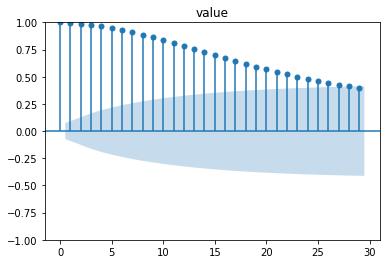

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


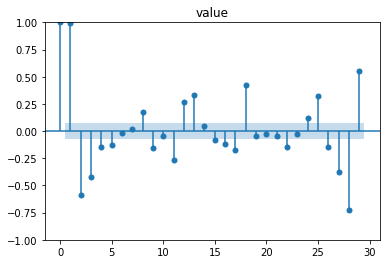

In [4]:
# 白噪声检验
acorr_ljungbox(train['value'], lags = [6, 12],boxpierce=True)
# 计算ACF
acf=plot_acf(train['value'])
plt.title("value")
plt.show()

# PACF
pacf=plot_pacf(train['value'])
plt.title("value")
plt.show()



/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


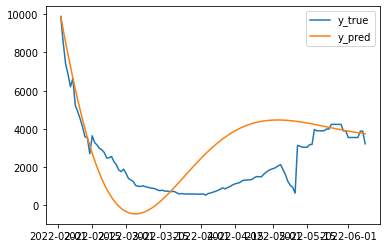

127


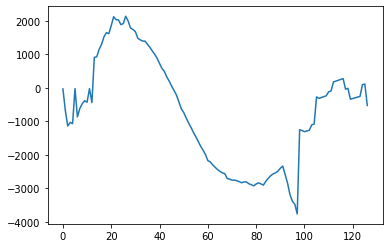

In [44]:
model = sm.tsa.arima.ARIMA(train['value'],order=(7,0,1))
arima_res=model.fit()
arima_res.summary()


predict=arima_res.predict("2022-02-02","2022-06-08")
plt.plot(test.index,test['value'])
plt.plot(test.index,predict)
plt.legend(['y_true','y_pred'])
plt.show()
print(len(predict))


from sklearn.metrics import r2_score,mean_absolute_error
mean_absolute_error(test['value'],predict)

res=test['value']-predict
residual=list(res)
plt.plot(residual)



/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


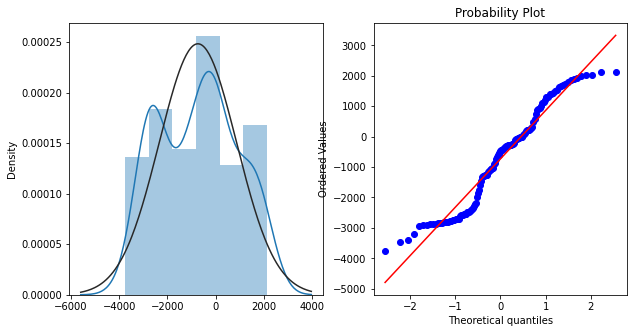

In [46]:
import seaborn as sns
from scipy import stats
plt.figure(figsize=(10,5))
ax=plt.subplot(1,2,1)
sns.distplot(residual,fit=stats.norm)
ax=plt.subplot(1,2,2)
res=stats.probplot(residual,plot=plt)
plt.show()


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:425: NoDataWarning: No jhu-csse confirmed_7dav_incidence_num data found on 20220615 for geography 'state'
  NoDataWarning)
/usr/local/lib/python3.7/site-packages/covidcast/covid

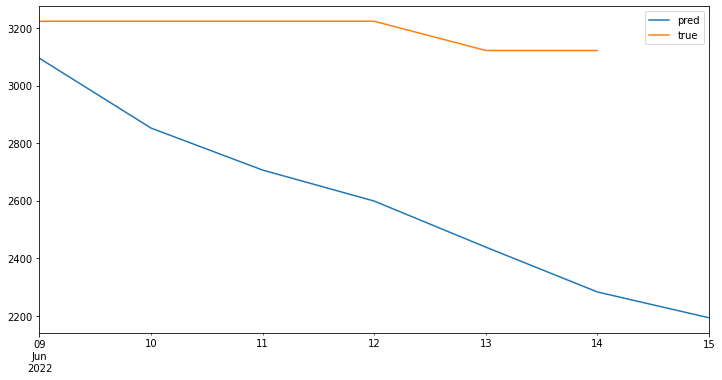

,pred,true
2022-06-09,3094.736324,3223.428571
2022-06-10,2852.175542,3223.428571
2022-06-11,2706.269751,3223.428571
2022-06-12,2598.499155,3223.428571
2022-06-13,2438.388515,3121.857143
2022-06-14,2282.585749,3121.857143
2022-06-15,2192.962048,NaN


In [41]:
model = sm.tsa.arima.ARIMA(df['value'],order=(7,0,1))
arima_res=model.fit()
arima_res.summary()


predict = pd.DataFrame()
predict["pred"]=arima_res.predict("2022-06-09",'2022-06-15')
import covidcast
from datetime import date
data_new = covidcast.signal("jhu-csse", "confirmed_7dav_incidence_num", date(2022,6,9), date(2022, 6,16),
                        "state", "pa")
data_new = data_new.set_index("time_value")
predict['true']=data_new['value']
predict.plot(figsize=(12,6))
plt.show()
predict





In [3]:
import sys
sys.path.append("../src/chimeric_tools/")

from Simulation import COVID
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.lines import Line2D

data = COVID().data

import sys
import numpy as np
import pandas as pd

from epiweeks import Week
   
unique_dates = data.date.unique()

fromDate2EW = { "date":[], "start_date":[], "end_date":[], "EW":[] }
for date in unique_dates:
    fromDate2EW["date"].append(date)

    dt = pd.to_datetime(date)
    week = Week.fromdate(dt)

    startdate = week.startdate()
    fromDate2EW["start_date"].append( startdate )

    enddate = week.enddate()
    fromDate2EW["end_date"].append( enddate )

    fromDate2EW["EW"].append( week.cdcformat() )
fromDate2EW = pd.DataFrame(fromDate2EW)

data = data.merge(fromDate2EW, on = ["date"])

def aggregate(x):
    cases =  x.value.sum()

    return pd.Series({"cases":cases})
    
weekly_date = data.groupby( ["location", "location_name", "start_date", "end_date", "EW"]).apply(aggregate)
weekly_date = weekly_date.reset_index()

In [5]:
data = weekly_date
data

,location,location_name,start_date,end_date,EW,cases
0,42,Pennsylvania,2020-01-19,2020-01-25,202004,0
1,42,Pennsylvania,2020-01-26,2020-02-01,202005,0
2,42,Pennsylvania,2020-02-02,2020-02-08,202006,0
3,42,Pennsylvania,2020-02-09,2020-02-15,202007,0
4,42,Pennsylvania,2020-02-16,2020-02-22,202008,0
...,...,...,...,...,...,...
119,42,Pennsylvania,2022-05-01,2022-05-07,202218,8808
120,42,Pennsylvania,2022-05-08,2022-05-14,202219,21316
121,42,Pennsylvania,2022-05-15,2022-05-21,202220,27317
122,42,Pennsylvania,2022-05-22,2022-05-28,202221,29664


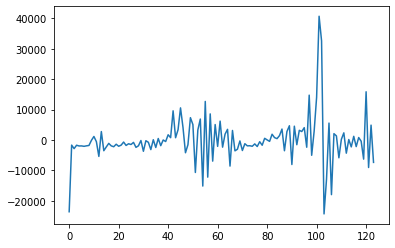

In [8]:
y = np.array(data["cases"][1:]).reshape(-1,)
# mod = sm.tsa.statespace.SARIMAX(data["cases"], order=(2,1,0))
mod = sm.tsa.arima.ARIMA(data["cases"],order=(7,0,1))

res = mod.fit()
residuals = res.resid
residuals.plot()
pred = res.predict()


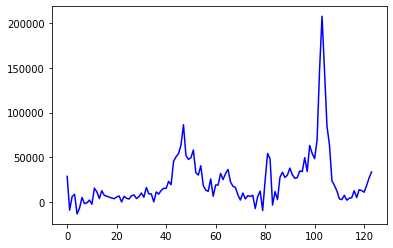

In [9]:
def NBB(x, block_size):
    """
    Non-overlapping Block Bootstrap
    """
    n = len(x)
    # check length of x 
    overflow_len = n % block_size
    if overflow_len != 0:
        x = x[:-overflow_len]
    n_blocks = int(n/block_size)
    blocks = np.array_split(x, n_blocks)
    d = []
    # randomly select n_blocks blocks from the list of blocks with replacement
    for i in range(n_blocks+1):
        d.append(blocks[np.random.randint(0, n_blocks)])
    [x for xs in d for x in xs]
    if overflow_len != 0:
        return [x for xs in d for x in xs][:-(block_size - overflow_len)]
    return [x for xs in d for x in xs]
d = NBB(residuals, 5)
new =  pred + d
plt.plot(new, color='blue')

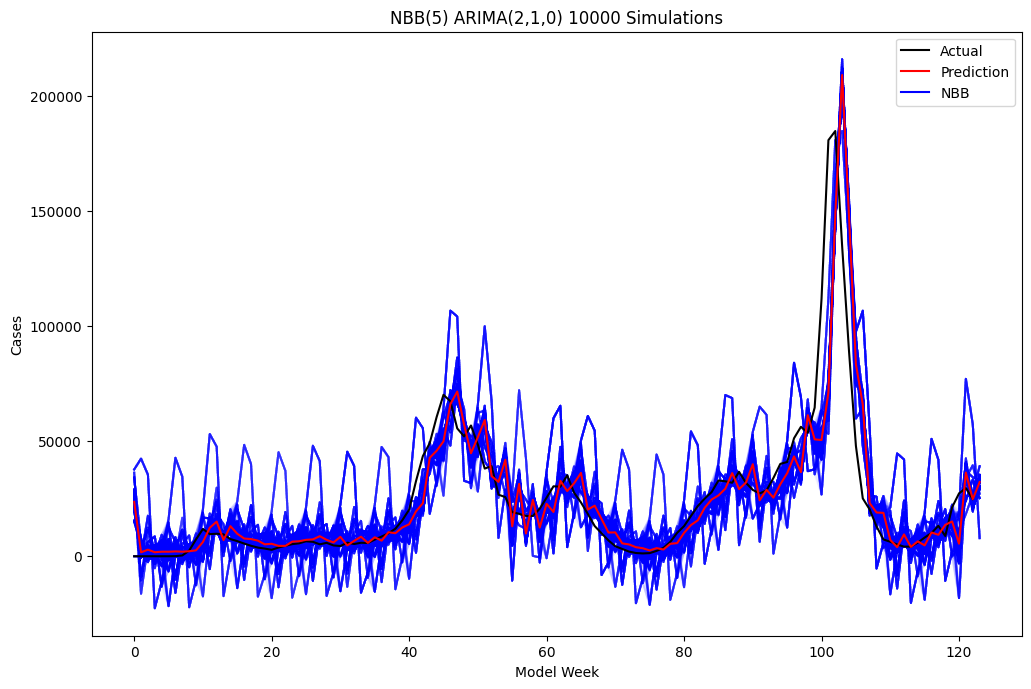

In [10]:
fig = plt.figure(figsize=(12,8), dpi=100)
for i in range(0,1000):
    d = NBB(residuals, 5)
    diff =  -(len(d)-(len(pred)))
    if diff == 0:
        new =  pred + d
    else:
        new = pred + d[:-(len(d)-(len(pred)))]
    plt.plot(new, color='blue', alpha=0.05)
plt.plot(y, color='black')
plt.plot(pred, color='red')
colors = ['black', 'red', 'blue']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = ['Actual', 'Prediction', 'NBB']
plt.legend(lines, labels)
plt.xlabel("Model Week")
plt.ylabel("Cases")
plt.title("NBB(5) ARIMA(2,1,0) 10000 Simulations")
# plt.savefig('NBB(5) ARIMA(2,1,0) 1000 Simulations.png', facecolor='white', transparent=False)